In [1]:
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
import pandas as pd
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def calculate_knn_outlier_scores(data, n_samples, sample_fraction, n_components, n_neighbors, contamination):
    """
    Performs outlier detection using PCA and KNN with voting mechanism, returning final labels and scores.
    
    Parameters:
        data (numpy.ndarray): The input dataset.
        n_samples (int): Number of random samples to generate.
        sample_fraction (float): Fraction of the data to include in each sample.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        contamination (float): Contamination level for KNN.
    
    Returns:
        numpy.ndarray: A binary array indicating whether each data point is an outlier (1) or not (0).
        numpy.ndarray: Average outlier scores for each data point.
    """
    n_data_points = data.shape[0]
    sample_size = int(n_data_points * sample_fraction)
    all_labels = np.zeros((n_samples, n_data_points), dtype=int)
    all_scores = np.zeros((n_samples, n_data_points), dtype=float)
    
    for i in range(n_samples):
        # Step 1: Random sampling
        sampled_indices = np.random.choice(n_data_points, sample_size, replace=False)
        sampled_data = data[sampled_indices]
        
        # Step 2: PCA transformation
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(sampled_data)
        
        # Step 3: KNN outlier detection
        knn = KNN(n_neighbors=n_neighbors, contamination=contamination)
        knn.fit(reduced_data)
        
        # Assign outlier labels and scores to the full dataset
        full_reduced_data = pca.transform(data)
        labels = knn.predict(full_reduced_data)
        scores = knn.decision_function(full_reduced_data)  # Outlier scores
        
        all_labels[i] = labels
        all_scores[i] = scores
    
    # Step 4: Voting mechanism
    final_labels = mode(all_labels, axis=0)[0].flatten()
    average_scores = all_scores.mean(axis=0)
    
    return final_labels, average_scores

def evaluate_knn_outlier_detection(y_true, y_pred, y_scores):
    """
    Evaluates outlier detection performance using Precision, Recall, and AUC.
    
    Parameters:
        y_true (numpy.ndarray): Ground truth (0 for inliers, 1 for outliers).
        y_pred (numpy.ndarray): Predicted labels (0 for inliers, 1 for outliers).
        y_scores (numpy.ndarray): Outlier scores for each data point.
    
    Returns:
        Precision, Recall, and AUC scores.
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    return  precision, recall, auc



Number of training samples: 3400
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.5518153230417382
Best k (Number of Neighbors): 25
Best n_components (PCA): 13


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


Test Set Performance:
Precision: 0.01694915254237288
Recall: 0.05
AUC: 0.6277222777222776


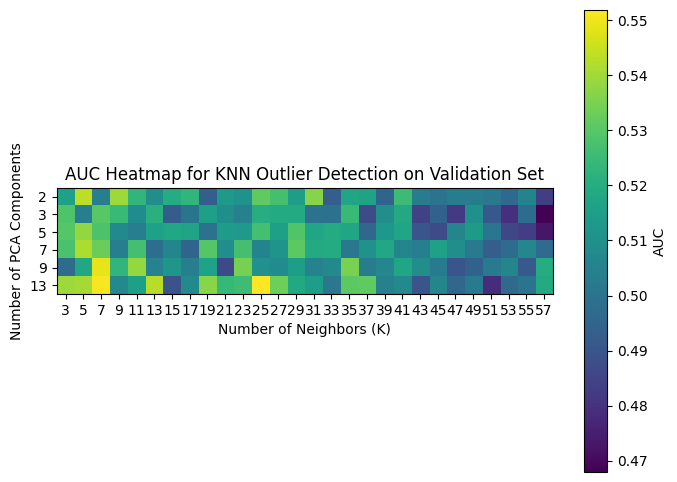

In [39]:
# KNN
# dataset: Annthyroid_norm_02_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Annthyroid\\Annthyroid_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (50% train, 35% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 123
Testing K values: [3, 5, 7, 9, 11]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.9764705882352941
Best k (Number of Neighbors): 3
Best n_components (PCA): 3
Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 1.0


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


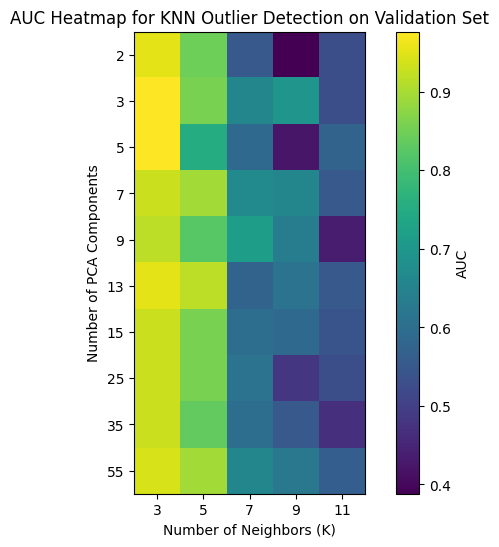

In [36]:
# KNN
# dataset: Arrhythmia_withoutdupl_norm_02_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Arrhythmia\\Arrhythmia_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (50% train, 35% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 25, 35, 55]   # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 1180
Testing K values: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.964765100671141
Best k (Number of Neighbors): 3
Best n_components (PCA): 13


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.9108040201005024


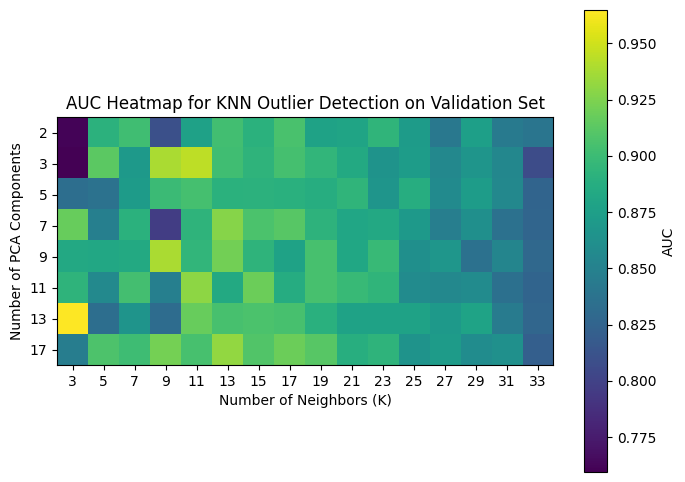

In [38]:
# KNN
# dataset: Cardiotocography_norm_02_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Cardiotocography\\Cardiotocography_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11, 13, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [32]:
# KNN
# dataset: HeartDisease_withoutdupl_norm_02_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\HeartDisease\\HeartDisease_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 11]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Number of training samples: 34
Testing K values: [3, 5]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.8260869565217391
Best k (Number of Neighbors): 5
Best n_components (PCA): 5
Test Set Performance:
Precision: 0.0
Recall: 0.0
AUC: 0.9


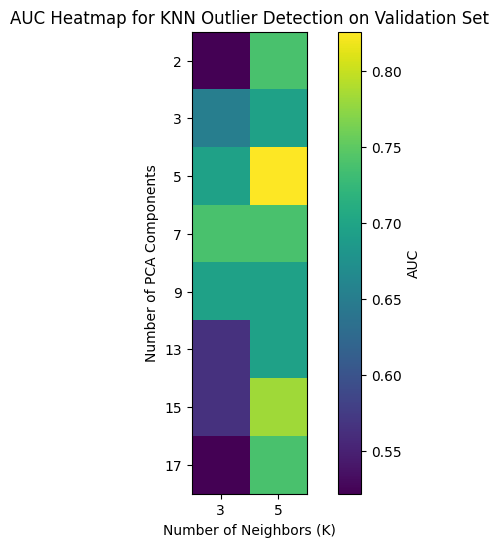

In [20]:
# KNN
# dataset: Hepatitis_withoutdupl_norm_05_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Hepatitis\\Hepatitis_withoutdupl_norm_05_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (50% train, 35% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


Number of training samples: 73
Testing K values: [3, 5, 7]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 1.0
Best k (Number of Neighbors): 7
Best n_components (PCA): 9
Test Set Performance:
Precision: 1.0
Recall: 1.0
AUC: 1.0


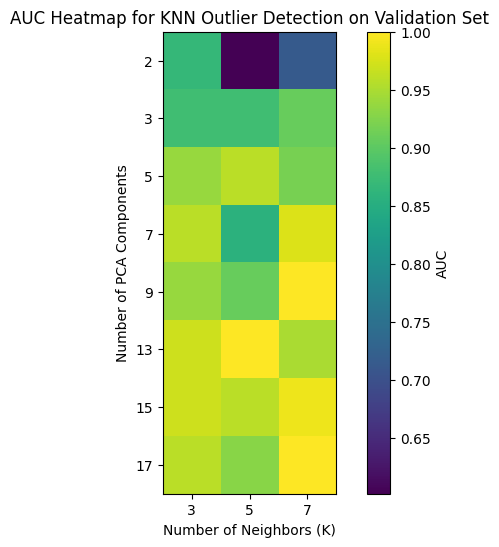

In [19]:
# KNN
# dataset: Lymphography_withoutdupl_norm_1ofn.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Lymphography\\Lymphography_withoutdupl_norm_1ofn.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-2].values

# Separate labels (last column)
labels = df.iloc[:, -2].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


In [17]:
# KNN
# dataset: Parkinson_withoutdupl_norm_05_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


file_path = "G:\\Nazanin\\B project\\code\\dataset\\Parkinson\\Parkinson_withoutdupl_norm_05_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 9, 13, 15, 17]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Number of training samples: 254
Testing K values: [3, 5, 7, 9, 11, 13, 15]


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()
C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

Maximum AUC on Validation Set: 0.8685714285714284
Best k (Number of Neighbors): 11
Best n_components (PCA): 3
Test Set Performance:
Precision: 0.14285714285714285
Recall: 0.5
AUC: 0.7866666666666666


C:\Users\asus\AppData\Local\Temp\ipykernel_10768\1477799171.py:51: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_labels = mode(all_labels, axis=0)[0].flatten()


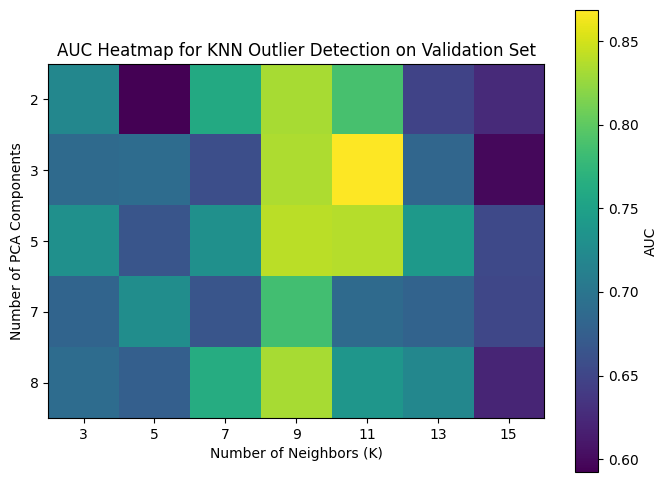

In [44]:
# KNN
# dataset: Pima_withoutdupl_norm_02_v01.csv
# tvt 50 35 15
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_path = "G:\\Nazanin\\B project\\code\\dataset\\Pima\\Pima_withoutdupl_norm_02_v01.csv"

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Separate data (all columns except the last)
data = df.iloc[:, :-1].values

# Separate labels (last column)
labels = df.iloc[:, -1].values

# Split the data into train, validation, and test sets (50% train, 35% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# Dynamically calculate odd K values based on the training set size
N_train = len(X_train)  # Number of training samples
max_k = int(math.sqrt(N_train))  # sqrt(N) for the training set
k_values = [k for k in range(3, max_k + 1) if k % 2 == 1]  # Odd K values

print("Number of training samples:", N_train)
print("Testing K values:", k_values)

# Define the hyperparameter ranges
n_components_values = [2, 3, 5, 7, 8]  # Number of PCA components

# To store grid search results
results = []

# Perform grid search on the training set
for n_components in n_components_values:
    for k in k_values:
        # Calculate KNN outlier scores on the training set
        predicted_labels, outlier_scores = calculate_knn_outlier_scores(
            X_train, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance on the validation set
        val_predicted_labels, val_outlier_scores = calculate_knn_outlier_scores(
            X_val, n_samples=5, sample_fraction=0.8,
            n_components=n_components, n_neighbors=k, contamination=0.1
        )
        
        # Evaluate the performance
        precision, recall, auc = evaluate_knn_outlier_detection(y_val, val_predicted_labels, val_outlier_scores)
        
        # Store results (n_components, k, precision, recall, auc)
        results.append((n_components, k, precision, recall, auc))

# Convert results to a structured array for analysis
results = np.array(results, dtype=[('n_components', int), ('k', int), 
                                    ('precision', float), ('recall', float), ('auc', float)])

# Find the best parameters based on the maximum AUC
max_auc_index = np.argmax(results['auc'])
max_auc = results['auc'][max_auc_index]
best_k = results['k'][max_auc_index]
best_n_components = results['n_components'][max_auc_index]

# Print the best results from validation
print(f"Maximum AUC on Validation Set: {max_auc}")
print(f"Best k (Number of Neighbors): {best_k}")
print(f"Best n_components (PCA): {best_n_components}")

# Evaluate the performance on the test set using the best parameters
test_predicted_labels, test_outlier_scores = calculate_knn_outlier_scores(
    X_test, n_samples=5, sample_fraction=0.8,
    n_components=best_n_components, n_neighbors=best_k, contamination=0.1
)

test_precision, test_recall, test_auc = evaluate_knn_outlier_detection(y_test, test_predicted_labels, test_outlier_scores)

# Print test set performance
print(f"Test Set Performance:")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")

# Visualize the results: Heatmap for AUC
auc_matrix = np.zeros((len(n_components_values), len(k_values)))

# Fill the matrix with AUC scores
for i, n_components in enumerate(n_components_values):
    for j, k in enumerate(k_values):
        auc_matrix[i, j] = results[(results['n_components'] == n_components) & 
                                   (results['k'] == k)]['auc']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(auc_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='AUC')
plt.xticks(np.arange(len(k_values)), labels=k_values)
plt.yticks(np.arange(len(n_components_values)), labels=n_components_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Number of PCA Components')
plt.title('AUC Heatmap for KNN Outlier Detection on Validation Set')
plt.show()
